# PANDA Inference Testing

This notebook uses the holdout set of 800 images from the PANDA Image Extraction notebook to build the inference code for the final submission and test the performance of the models that were trained.

## Workspace Initialization and Data Setup

In [2]:
# General purpose packages
import os
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
import json
import boto3
from shutil import copyfile
copyfile(src = "../input/edahelperfuncs/eda_helper_funcs.py", dst = "../working/eda_helper_funcs.py")
from eda_helper_funcs import *
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

# Image processing packages
import openslide
import cv2

# ML packages
import torch
from torch.utils.data import Dataset, DataLoader
import fastai
from fastai.vision import *
from fastai.learner import *

In [3]:
with open('../input/aws-creds/AWS_creds.json') as f:
    credentials = json.load(f)

s3client = boto3.client('s3',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'])
bucket = 'kitt-panda-data'

In [4]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'
test_dir = f'{BASE_PATH}/train_images'
test_df = pd.read_csv('../input/panda-image-extraction/test_set.csv')
test_df.reset_index(drop=True,inplace=True)
print('Test dataframe shape: ', test_df.shape)
test_df.head()

Test dataframe shape:  (800, 4)


,image_id,data_provider,isup_grade,gleason_score
0,7e61d1d767697f88ab5c32e9074d5196,karolinska,4,4+4
1,b625717ff0c0764edc883bc360e30d30,karolinska,1,3+3
2,aa082e66a044358b7222c7e2fb499a2b,radboud,3,4+3
3,0ffe691b5af61da422c79762c902ba78,karolinska,0,0+0
4,9a22abb1da9fc91bb8ae7b91bfe1451e,radboud,3,4+3


### Create Pipeline for Processing and Running Inference on Images

In [5]:
def test_inference(image_id,data_dir = test_dir,views=4,sz=256,lvl=1,tta_flip=True,df=test_df):
    """Creates and returns np arrays corresponding to the desired views of the input image
    
    Inputs:
        image_id: string, sample id from the training dataframe
        data_dir: string, path to images to be used
        views: int, number of different grid placements to use to generate final images
        sz: int, pixel size per edge of the desired tiles
        lvl: int (0-2), resolution level at which the image processing is done
        tta_flip: boolean, whether flipped versions of the image will be included for inference
        df: dataframe, the dataframe that contains the scores for each sample image

        
    Output:
        np array of size (number of views (*2 if tta_flip=True),768,768,3)
    """
    img = open_slide_level(os.path.join(data_dir,f'{image_id}.tiff'), lvl)
    image_data_provider=df.loc[df['image_id']==image_id,'data_provider'].to_list()[0]
    num_tiles = 36
    images = []
    # Ensure that image is padded to properly fit a grid of full tiles
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    base_img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    base_shape = base_img.shape
    
    # Implement "views" number of grids and create final images
    for i in range(views):
        if i == 0:
            temp_img = base_img
        else:      
            temp_img = base_img[int(sz/views)*i:-int(sz/views)*(views-i),
                                int(sz/views)*i:-int(sz/views)*(views-i),
                                :]
        shape = temp_img.shape
        temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
        temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
        # Pad number of tiles to prevent worst case of all initial tiles being filtered out not leaving enough tiles to form a final image
        if len(temp_img) < num_tiles*2:
            temp_img = np.pad(temp_img,[[0,2*num_tiles-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255)
        
        chan_mean = np.mean(temp_img,axis=(1,2))
        sing_mean = np.mean(chan_mean, axis = 1)
        idxs = np.argsort(sing_mean)
        
        # Some Radboud images have pen marks on them, this experimentally determined threshold eliminates tiles with 
        # significant pen marks (see Appendix for experimentation)
        if image_data_provider == 'radboud':
            idxs = idxs[chan_mean[idxs][:,0]>180.0]
        # Re-sort the remaining idxs so that tiles that were originally next to eachother (horizontally at least) will
        # be placed back together and support image continuity
        idxs = sorted(idxs[:num_tiles])        
        
        # Stitch tiles back together into final image
        temp_img = temp_img[idxs]
        temp_list = []
        for j in range(6):
            temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],temp_img[j*6+3],
                                       temp_img[j*6+4],temp_img[j*6+5]),axis=1)
            temp_list.append(temp_row)
        temp_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],temp_list[3],temp_list[4],temp_list[5]),axis=0)
        images.append(cv2.resize(temp_img,dsize=(768,768),interpolation=cv2.INTER_AREA))
        
        # Create flipped images for tta if desired (tiles flipped individually)
        if tta_flip:
            images.append(cv2.resize(np.flip(temp_img,axis=(0,1)),dsize=(768,768),interpolation=cv2.INTER_AREA))
        
    return np.array(images)

Number of images produced:  8 
Test shape:  (8, 768, 768, 3)


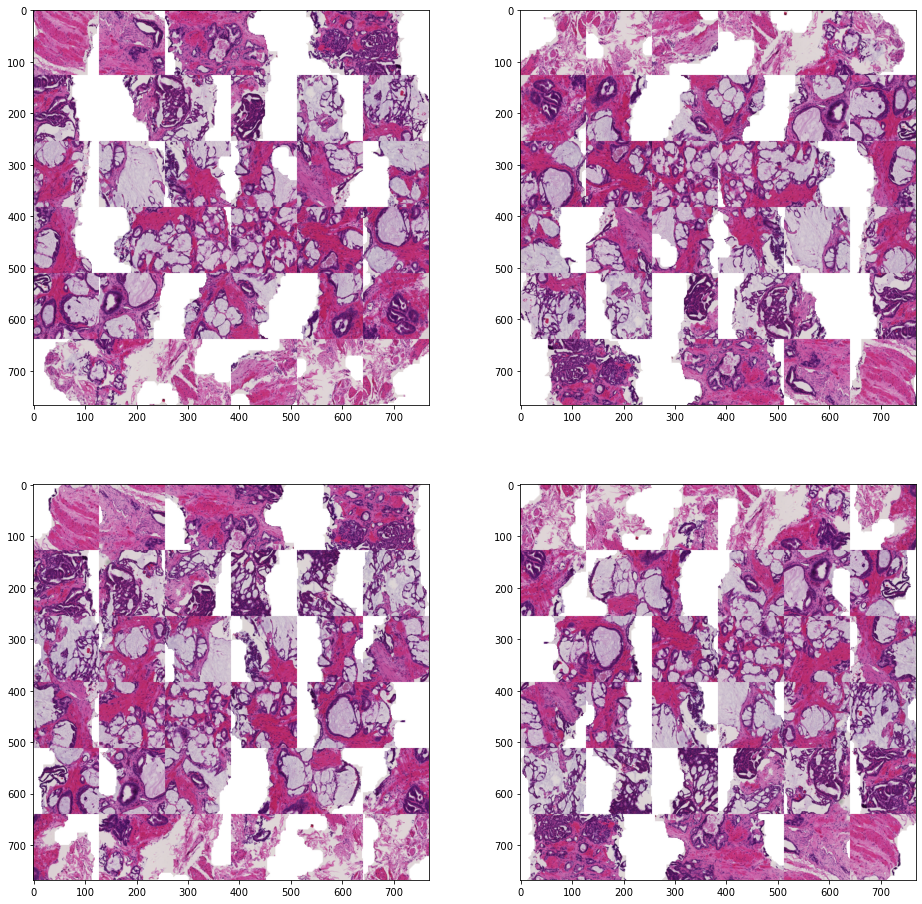

In [6]:
# Sanity check, 4 views with flips should produce 8 total images, in pairs that are flipped both horizontally and vertically
test= test_inference(image_id='7e61d1d767697f88ab5c32e9074d5196',data_dir = test_dir,views=4,sz=256,lvl=1,tta_flip=True)
print('Number of images produced: ',len(test),'\nTest shape: ',test.shape)
f, ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(test[0]);ax[0,1].imshow(test[1]);ax[1,0].imshow(test[6]);ax[1,1].imshow(test[7])

In [7]:
# Build class for dataset that the dataloader will use
class PandaDataset(Dataset):
    def __init__(self, im_id, views):
        self.views = views
        self.name = im_id
        
    def __len__(self):
        return self.views.shape[0]

    def __getitem__(self, idx):
        name = self.name
        view = self.views[idx]
        return view, name

In [8]:
# Load the trained models from fastai export files (easier than creating a full model, which recquires a dataset at inception 
# and then loading saved model weights), extract the core PyTorch model, set it to eval mode, and move it onto the GPU

for mod in ['direct36_densenet_pt_full_gc2.pkl','direct36_densenet_pt_full_2.pkl']:
    s3client.download_file(bucket,mod,mod)
learn1 = load_learner('direct36_densenet_pt_full_gc2.pkl')
mod1 = learn1.model;
mod1.float().eval();
mod1.cuda();
learn2 = load_learner('direct36_densenet_pt_full_2.pkl')
mod2 = learn2.model;
mod2.float().eval();
mod2.cuda();
# learn3 = load_learner('direct36_densenet_pt_full_3.pkl')
# mod3 = learn2.model;
# mod3.float().eval();
# mod3.cuda();

In [10]:
# Set variables and prepare empty lists for tracking predictions and checking results once completed
nworkers = 4
bs = 8

means = torch.Tensor([0.85780565, 0.70644778, 0.8043354])
stdevs = torch.Tensor([0.13791688, 0.24553864, 0.1628726])

test_ids=[]
test_preds=[]
mod1_preds=[]
mod1_view_1s = []; mod1_view_2s = []; mod1_view_3s = []; mod1_view_4s = []
mod1_view_5s = []; mod1_view_6s = []; mod1_view_7s = []; mod1_view_8s = []
mod2_preds=[]
mod2_view_1s = []; mod2_view_2s = []; mod2_view_3s = []; mod2_view_4s = []
mod2_view_5s = []; mod2_view_6s = []; mod2_view_7s = []; mod2_view_8s = []
# mod3_preds=[]
# mod3_view_1s = []; mod3_view_2s = []; mod3_view_3s = []; mod3_view_4s = []
# mod3_view_5s = []; mod3_view_6s = []; mod3_view_7s = []; mod3_view_8s = []

activations = []
data_provider = []
actual_isup = []

### Run Inference and Record Results

In [11]:
if os.path.exists(test_dir): # quirk of kaggle for hiding competition test sets
    for ind in tqdm(test_df.index):
        test_im = test_df['image_id'][ind]
        data_prov = test_df['data_provider'][ind]
        isup = test_df['isup_grade'][ind]
        px = torch.Tensor([255.0])
        test_ids.append(test_im); data_provider.append(data_prov); actual_isup.append(isup)
        
        # Get the condensed view images for the sample
        views= torch.Tensor(test_inference(image_id=test_im,data_dir = test_dir,views=4,sz=256,lvl=1,tta_flip=True))
        
        # Divide pixel values by 255 and normalize
        views = ((views/px-means)/stdevs).permute(0,3,1,2)

        temp_ds = PandaDataset(im_id=test_im,views=views)
        temp_dl = DataLoader(temp_ds, batch_size=bs, num_workers=nworkers, shuffle=False)
        with torch.no_grad():
            for x,_ in temp_dl:
                x = x.cuda()
                # Get the predictions from both models, each pred of the form [p(0),p(1),p(2),p(3),p(4),p(5)] and stack as rows
                preds = torch.cat((mod1(x),mod2(x)),0) #,mod3(x)
                # Take the mean of each column (average probability of class x) and use the highest average as the overall prediction
                pred = torch.argmax(preds.mean(0)).tolist();test_preds.append(pred)
                # Same to track results of model 1
                mod1_pred = torch.argmax(preds[ 0: 8].mean(0)).tolist();mod1_preds.append(mod1_pred)
                # Same to track results of model 2
                mod2_pred = torch.argmax(preds[ 8:16].mean(0)).tolist();mod2_preds.append(mod2_pred)
#                 # Same to track results of model 3
#                 mod3_pred = torch.argmax(preds[16:24].mean(0)).tolist();mod3_preds.append(mod3_pred)

                # Same but without taking mean along the 0 axis to get the individual predition from each view in each model
                view_preds = torch.argmax(preds,axis=1).tolist()
                mod1_view_1s.append(view_preds[0]);mod1_view_2s.append(view_preds[1]);mod1_view_3s.append(view_preds[2]);
                mod1_view_4s.append(view_preds[3]);mod1_view_5s.append(view_preds[4]);mod1_view_6s.append(view_preds[5]);
                mod1_view_7s.append(view_preds[6]);mod1_view_8s.append(view_preds[7]);
                
                mod2_view_1s.append(view_preds[8]);mod2_view_2s.append(view_preds[9]);mod2_view_3s.append(view_preds[10]);
                mod2_view_4s.append(view_preds[11]);mod2_view_5s.append(view_preds[12]);mod2_view_6s.append(view_preds[13]);
                mod2_view_7s.append(view_preds[14]);mod2_view_8s.append(view_preds[15]);
                
#                 mod3_view_1s.append(view_preds[16]);mod2_view_2s.append(view_preds[17]);mod2_view_3s.append(view_preds[18]);
#                 mod3_view_4s.append(view_preds[19]);mod2_view_5s.append(view_preds[20]);mod2_view_6s.append(view_preds[21]);
#                 mod3_view_7s.append(view_preds[22]);mod2_view_8s.append(view_preds[23]);

                
                # Store the final activations as well so we can tell if the classification format is an issue (i.e. real class = 4 and the model predicts
                # something like 0 as its highest probability but 4 as the second highest probability which would give a large error to the kappa score)
                # if this is the case we may need to switch to a regression model instead of a classification model
                acts = preds.mean(0);activations.append(acts.tolist())

                

    sub_df = pd.DataFrame({'image_id':test_ids,'final_isup_prediction':test_preds,'actual_isup':actual_isup,
                           'mod1_pred':mod1_preds,'mod2_pred':mod2_preds,
#                            'mod3_pred':mod3_preds,'mod4_pred':mod4_preds,'mod5_pred':mod5_preds,
                           'mod1_view1_pred':mod1_view_1s,'mod1_view2_pred':mod1_view_2s,'mod1_view3_pred':mod1_view_3s,
                           'mod1_view4_pred':mod1_view_4s,'mod1_view5_pred':mod1_view_5s,'mod1_view6_pred':mod1_view_6s,
                           'mod1_view7_pred':mod1_view_7s,'mod1_view8_pred':mod1_view_8s,
                           
                           'mod2_view1_pred':mod2_view_1s,'mod2_view2_pred':mod2_view_2s,'mod2_view3_pred':mod2_view_3s,
                           'mod2_view4_pred':mod2_view_4s,'mod2_view5_pred':mod2_view_5s,'mod2_view6_pred':mod2_view_6s,
                           'mod2_view7_pred':mod2_view_7s,'mod2_view8_pred':mod2_view_8s,
                           
#                            'mod3_view1_pred':mod3_view_1s,'mod3_view2_pred':mod3_view_2s,'mod3_view3_pred':mod3_view_3s,
#                            'mod3_view4_pred':mod3_view_4s,'mod3_view5_pred':mod3_view_5s,'mod3_view6_pred':mod3_view_6s,
#                            'mod3_view7_pred':mod3_view_7s,'mod3_view8_pred':mod3_view_8s,                           
                           
                           'activations':activations,
                           'data_provider':data_provider}
                         )

  0%|          | 0/800 [00:00<?, ?it/s]

In [19]:
sub_df.to_csv('direct36_2mod_inference.csv')
sub_df.to_pickle('direct36_2mod_inference.pkl')
sub_df.head(10)

,image_id,final_isup_prediction,actual_isup,mod1_pred,mod2_pred,mod1_view1_pred,mod1_view2_pred,mod1_view3_pred,mod1_view4_pred,mod1_view5_pred,...,mod2_view1_pred,mod2_view2_pred,mod2_view3_pred,mod2_view4_pred,mod2_view5_pred,mod2_view6_pred,mod2_view7_pred,mod2_view8_pred,activations,data_provider
0,7e61d1d767697f88ab5c32e9074d5196,3,4,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,"[-1.100696325302124, -1.2439618110656738, -0.48693275451660156, 1.8179441690444946, 1.1693960428237915, -1.4400978088378906]",karolinska
1,b625717ff0c0764edc883bc360e30d30,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"[0.1288071572780609, 1.9389212131500244, 0.9783402681350708, -0.17571298778057098, -0.9931463003158569, -1.5655343532562256]",karolinska
2,aa082e66a044358b7222c7e2fb499a2b,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0.7625638842582703, -0.6595303416252136, -1.9334700107574463, -1.3520087003707886, -0.5117043256759644, -1.783084750175476]",radboud
3,0ffe691b5af61da422c79762c902ba78,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"[0.1294335126876831, 1.2216975688934326, 0.07289014756679535, -0.8921231627464294, -0.13413378596305847, -1.3793399333953857]",karolinska
4,9a22abb1da9fc91bb8ae7b91bfe1451e,3,3,3,3,3,4,3,3,3,...,3,3,3,3,3,3,3,3,"[-2.031215190887451, -1.0072355270385742, 0.9692918062210083, 1.9775617122650146, 1.3096883296966553, -1.1224391460418701]",radboud
5,3ee71993acdc2ab83790ea25fafe319d,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"[-1.1682490110397339, 1.2853883504867554, 0.6521899700164795, -0.10132066160440445, -0.5218154788017273, -1.5365405082702637]",radboud
6,59afbd8eceb90a30ccfb99eb039fa5eb,3,3,2,3,2,2,2,2,2,...,3,3,3,3,3,3,3,3,"[-1.4324613809585571, -0.37342727184295654, 1.6183724403381348, 1.8496050834655762, 0.18117396533489227, -1.1959261894226074]",radboud
7,46376a1b1f9b346305dfbc259dcb0b03,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,"[1.625179648399353, 0.8104876279830933, -1.1902390718460083, -1.0786490440368652, -1.2947397232055664, -1.1540895700454712]",karolinska
8,4e94a11759c86bca9836e27cfd2fb670,4,3,4,4,4,4,3,3,4,...,4,4,4,4,4,4,4,4,"[-2.6420345306396484, -1.1691876649856567, 0.13198918104171753, 1.4172768592834473, 1.905836582183838, 1.2983423471450806]",karolinska
9,50a159e2f93214ad4ebb0ec9c5d428f7,0,0,0,1,0,0,0,0,0,...,5,5,5,0,1,1,1,1,"[-0.47302478551864624, -1.1135244369506836, -2.379490613937378, -1.3368419408798218, -1.0433868169784546, -0.8526111841201782]",radboud


### Results Analysis

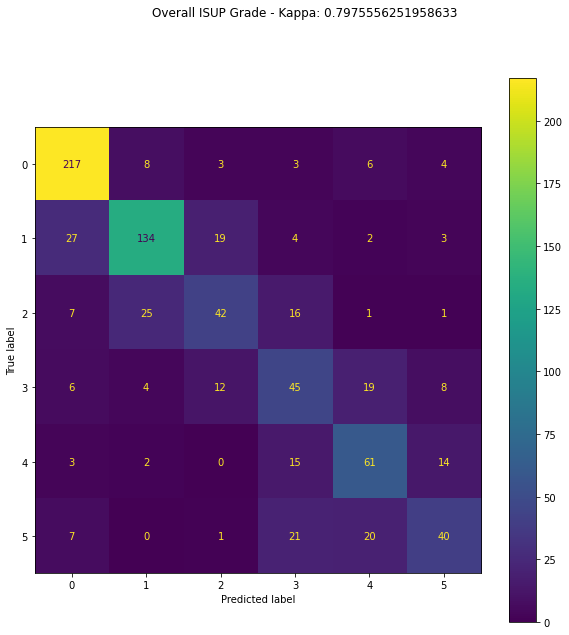

In [13]:
# Check overall kappa score and confusion matrix
f, axs = plt.subplots(1,1, figsize=(10,10))
p = sub_df['final_isup_prediction']
t = sub_df['actual_isup']
isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
ConfusionMatrixDisplay(confusion_matrix(t,p,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs)
plt.suptitle(f'Overall ISUP Grade - Kappa: {isup_kappa}')
plt.savefig('direct36_2mod_confusion.png')

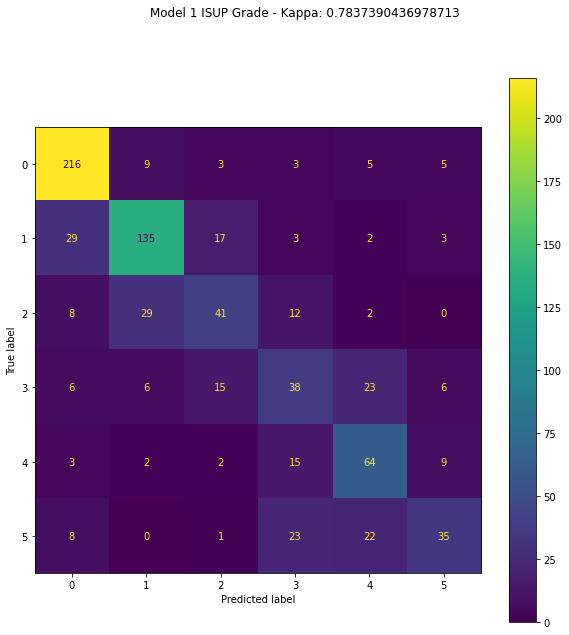

In [20]:
# Check the model #1 kappa score and confusion matrix
f, axs = plt.subplots(1,1, figsize=(10,10))
p = sub_df['mod1_pred']
t = sub_df['actual_isup']
isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
ConfusionMatrixDisplay(confusion_matrix(t,p,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs)
plt.suptitle(f'Model 1 ISUP Grade - Kappa: {isup_kappa}')
plt.savefig('direct36big_mod1_confusion.png')

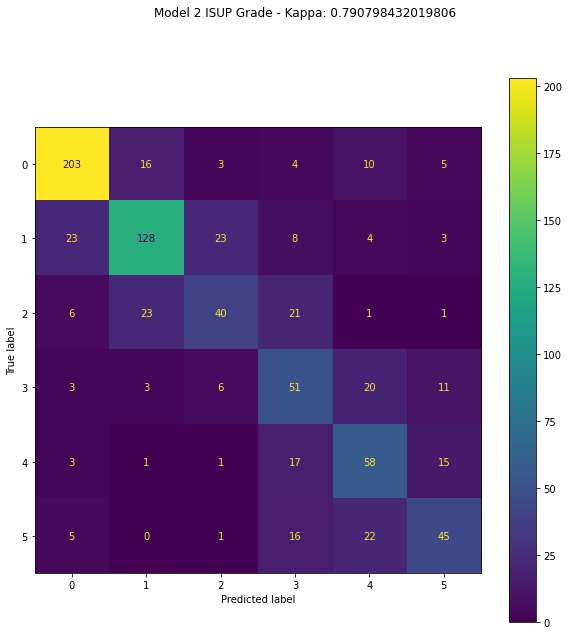

In [21]:
# Check the model #2 kappa score and confusion matrix
f, axs = plt.subplots(1,1, figsize=(10,10))
p = sub_df['mod2_pred']
t = sub_df['actual_isup']
isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
ConfusionMatrixDisplay(confusion_matrix(t,p,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs)
plt.suptitle(f'Model 2 ISUP Grade - Kappa: {isup_kappa}')
plt.savefig('direct36_mod2_confusion.png')

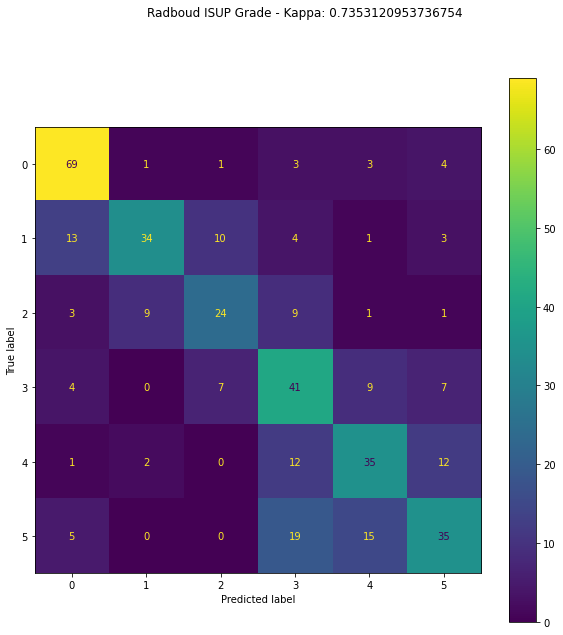

In [16]:
# Check performance on the Raboud center's data
rad_df = sub_df.loc[sub_df['data_provider']=='radboud']
f, axs = plt.subplots(1,1, figsize=(10,10))
p = rad_df['final_isup_prediction']
t = rad_df['actual_isup']
isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
ConfusionMatrixDisplay(confusion_matrix(t,p,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs)
plt.suptitle(f'Radboud ISUP Grade - Kappa: {isup_kappa}')
plt.savefig('rad_direct36_2mod_confusion.png')

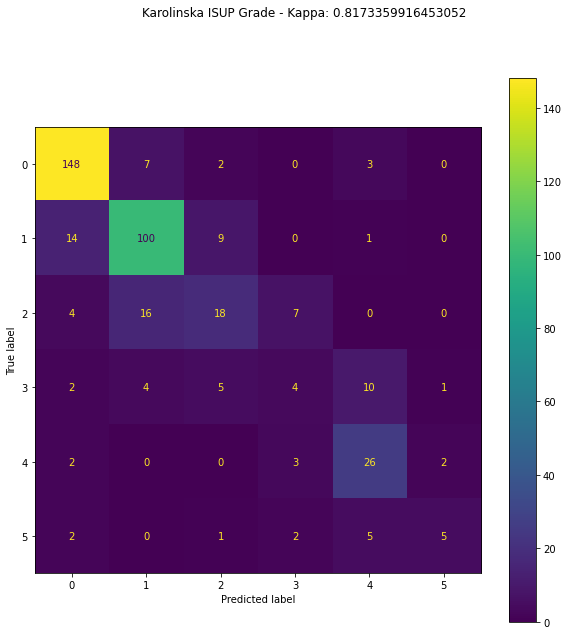

In [17]:
# Check performance on the Karolinska data
kar_df = sub_df.loc[sub_df['data_provider']=='karolinska']
f, axs = plt.subplots(1,1, figsize=(10,10))
p = kar_df['final_isup_prediction']
t = kar_df['actual_isup']
isup_kappa = cohen_kappa_score(t,p,weights='quadratic')
ConfusionMatrixDisplay(confusion_matrix(t,p,labels = [0,1,2,3,4,5]),
                       display_labels = [0,1,2,3,4,5]).plot(ax = axs)
plt.suptitle(f'Karolinska ISUP Grade - Kappa: {isup_kappa}')
plt.savefig('kar_direct36_2mod_confusion.png')

### Conclusion

It is not suprising to find a significant difference in performance between the Raboud and Karolinska data sets since Karolinska is more heavily weighted toward easily distinguished lower grade cancer or no cancer at all (ISUP = 0 or 1), while the Radboud set is more heavily weighted toward the much more difficult to distinguish ISUP grades 3-5.

One issue that is apparent in the activations that were saved is that due to the model structuring as a classification task we do get instances where the two largest activations are for very different classes which causes a large weighting in the kappa scoring. For example, sample 5000f1e3635cd4bf1ac50930e885e935 received the final activations \[0.67, -1.62, -1.21, -0.44, 0.08, 0.45\] (prior to the final softmax layer for classification), the correct label, ISUP=5 received the second highest activation but the fursthest possible class, ISUP=0 received the highest probability and therefore the model's prediction, resulting in a large error weighting in the quadratic weighted kappa score. In order to resolve this there are a few approaches that could be the subject of further research. First, instead of classification we could structure the model to perform regression on the range 0-5, so that near misses ought to be classified nearby within that range rather be assigned to the next highest, arbitrarily related class. Alternatively we could restructure the model and the labels into a multi-class classification problem where each image is assigned to its own class AND all of the classes below that. In this instance a sample that is ISUP=4 would be assigned to 0,1,2,3,and 4, and the model would take the highest predicted class as its prediction. So if the 4 label is missed, theoretically the 3 label will hopefully be caught and the error will only receive a weighting of 1 (4-3)^2=1. This method would work in the reverse way as well with a sample being labeled to all of the classes above its actual label and the lowest predicted label selected, but in the real world some analysis would have to be done to conclude which outcome is preferable (choosing the error type of erring in prediction to the low side or the high side - is it more "costly" to initially proceed with a lower level of treatment or more aggressive treatment).

A final note: The models used in this inference notebook were trained slightly less than the models used for submission to the competition, combined with the more stringent consensus building from the competition hosts / labelers on the final test set to reduce the noise that exists in the training set, the performance above is significantly below my final perfomance in the competition.

![Final Submission](panda_inference_score.JPG "Final Submission")
